In [1]:
## ライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import time
import random
from qulacs import QuantumState
from qulacs.state import inner_product
from qulacs import QuantumCircuit
from qulacs.gate import to_matrix_gate
from qulacs import QuantumState
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算

In [2]:
global_nqubits = 5

## 理想的な回路作成

In [3]:
# 係数の絶対値の分布をプロットする関数
def show_distribution(state, nqubits):
    plt.bar([i for i in range(pow(2, nqubits))], abs(state.get_vector()))
    plt.xlabel('量子ビット')
    plt.ylabel('確率')
    plt.show()

### 動作の確認
まずは5量子ビットのアルゴリズムを実装し、動作を確認する。

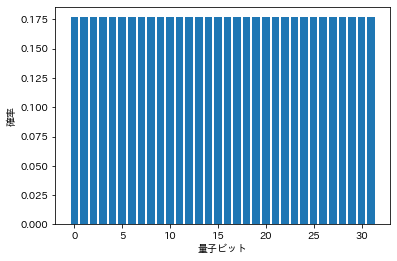

In [4]:
nqubits = 5
state = QuantumState(nqubits)
state.set_zero_state()

def make_Hadamard(nqubits):
    Hadamard = QuantumCircuit(nqubits)
    for i in range(nqubits):
        Hadamard.add_gate(H(i))
    return  Hadamard

Hadamard = make_Hadamard(nqubits)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [5]:
# オラクルU_wの作成
def make_U_w(nqubits):
    U_w = QuantumCircuit(nqubits)
    CnZ = to_matrix_gate(Z(nqubits-1))
    # i-th qubitが全て1の場合だけゲートを作用
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 1
        CnZ.add_control_qubit(control_index, control_with_value)
    U_w.add_gate(CnZ)
    return U_w

In [6]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[ 0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j
  0.1767767+0.j  0.1767767+0.j  0.1767767+0.j -0.1767767+0.j]


In [7]:
# 反転U_sを作る
def make_U_s(nqubits):
    U_s = QuantumCircuit(nqubits)
    for i in range(nqubits):
        U_s.add_gate(H(i))

    ## 2|0><0| - I の実装
    U_s.add_gate(to_matrix_gate(RZ(nqubits-1, 2*np.pi))) ## まず、位相(-1)を全ての状態に付与する。ゲート行列はarrary([[-1,0],[0,-1]])
    U_s.add_gate( X(nqubits-1) )
    ## 全てのi-th qubitが0の場合だけZゲートを作用させる
    CnZ = to_matrix_gate(Z(nqubits-1))
    for i in range(nqubits-1):
        control_index = i
        control_with_value = 0
        CnZ.add_control_qubit(control_index, control_with_value)
    U_s.add_gate( CnZ )
    U_s.add_gate( X(nqubits-1) )

    for i in range(nqubits):
        U_s.add_gate(H(i))

    return U_s

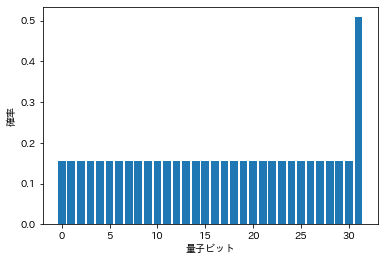

In [8]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

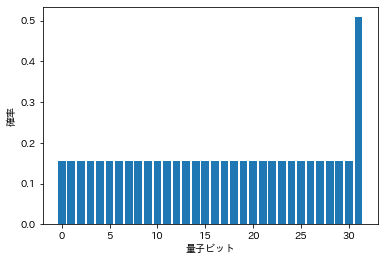

0.5082329989778305


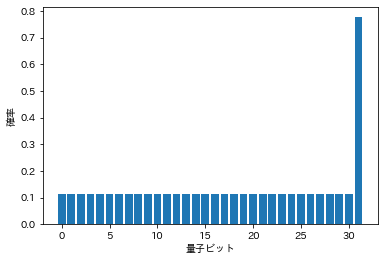

0.7761601777867947


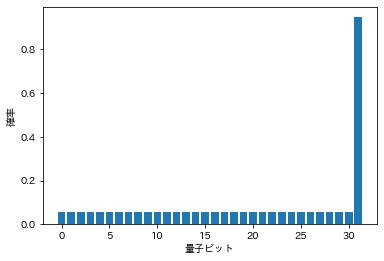

0.9470673343724091


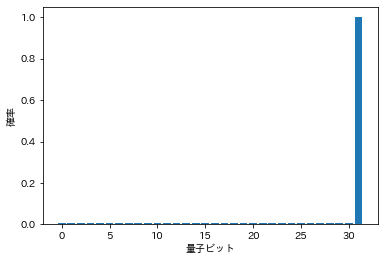

0.9995910741614723


In [9]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823


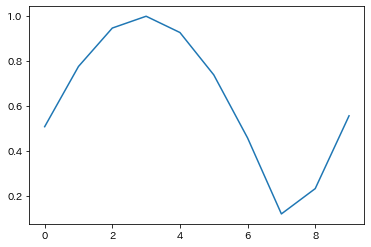

In [10]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

avg_result = []
times = 10
for i in range(times):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.plot(avg_result)

In [11]:
# グローバーのアルゴリズム
def grover(nqubits, operate_times):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    Hadamard = make_Hadamard(nqubits)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        print(fuga)


    max_k = np.argmax(result)
    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの試行回数k')
    plt.ylabel('確率')
    plt.show()

0.5082329989778305
0.7761601777867947
0.9470673343724091
0.9995910741614723
0.9271659296803515
0.738845043989187
0.4581685277993745
0.1202209456346408
0.23275425473442243
0.5566351732616823
maximal probability 9.995911e-01 is obtained at k = 4


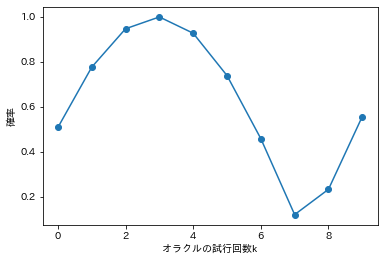

In [12]:
grover(5, 10)

## ノイズを入れてみる。
http://docs.qulacs.org/ja/latest/guide/2.0_python_advanced.html#id37

In [13]:
from qulacs.gate import DephasingNoise
from qulacs.gate import Probabilistic

In [14]:
def make_noisy_Hadamard(nqubits, dephasing_rate):
    Hadamard = QuantumCircuit(nqubits)
    # dphe_gate = DephasingNoise(0, dephasing_rate)
    distribution = [1 - dephasing_rate, dephasing_rate]
    for i in range(nqubits):
        gate_list = [H(i), Identity(i)]
        gate = Probabilistic(distribution, gate_list)
        # Hadamard.add_gate(H(i))
        Hadamard.add_gate(gate)
    return  Hadamard

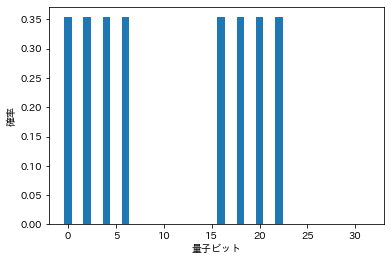

In [15]:
nqubits = 5
dephasing_rate = 0.5
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
Hadamard.update_quantum_state(state)

show_distribution(state, nqubits)

In [16]:
fuga = state.copy()
U_w = make_U_w(nqubits)
U_w.update_quantum_state(fuga)
print(fuga.get_vector())

[0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.35355339+0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]


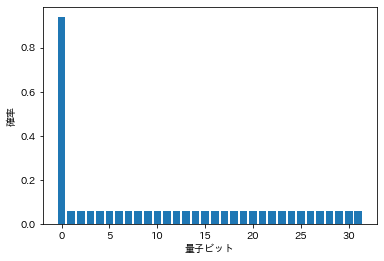

In [17]:
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

## U_s U_w を作用
U_s = make_U_s(nqubits)
U_w.update_quantum_state(state)
U_s.update_quantum_state(state)
show_distribution(state,nqubits)

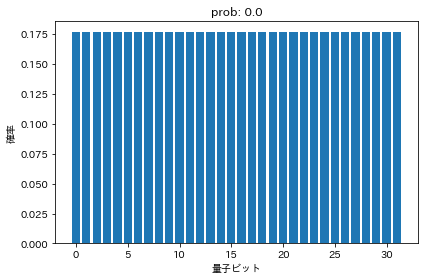

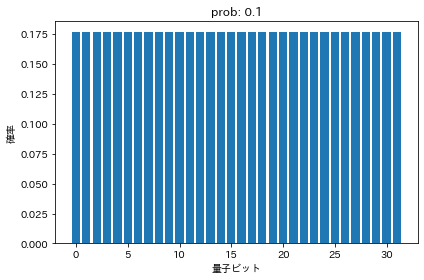

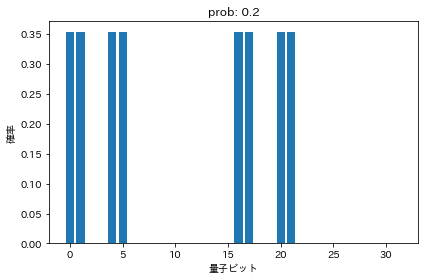

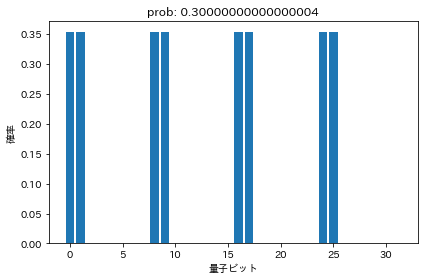

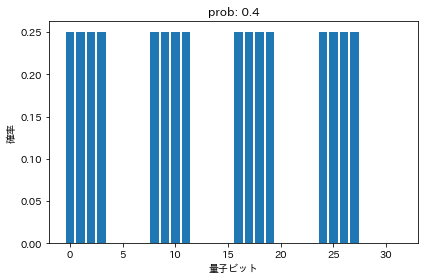

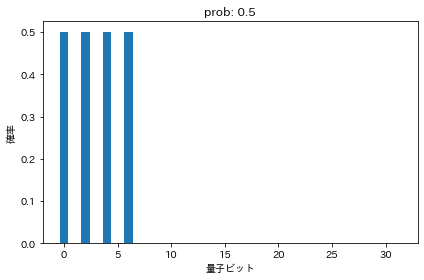

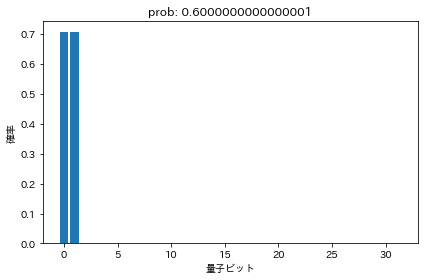

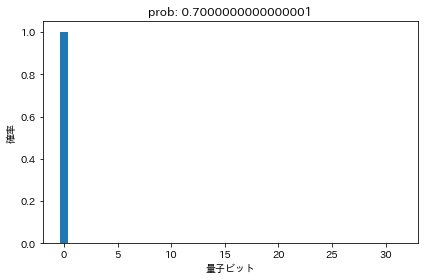

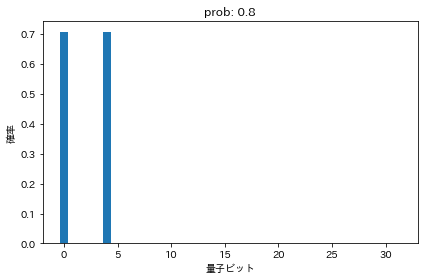

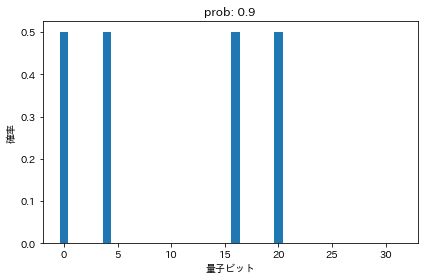

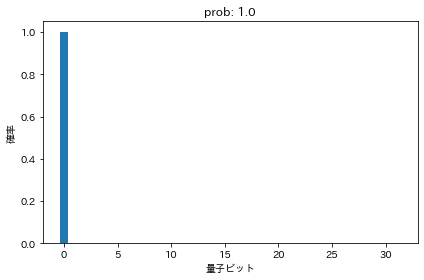

In [18]:
for i in range(0, 11):
    nqubits = 5
    dephasing_rate = i * 0.1 # p = dephasing_rateとして計算
    state = QuantumState(nqubits)
    state.set_zero_state()

    Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    Hadamard.update_quantum_state(state)

    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'prob: {dephasing_rate}')
    plt.xlabel('量子ビット数')
    plt.ylabel('確率')
    show_distribution(state, nqubits)


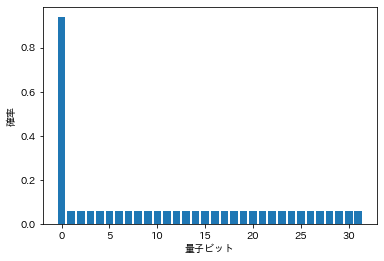

0.06249999999999995


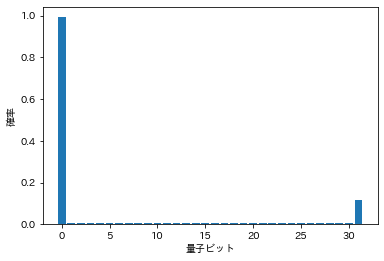

0.11718749999999978


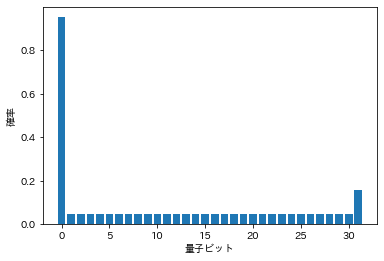

0.15722656249999956


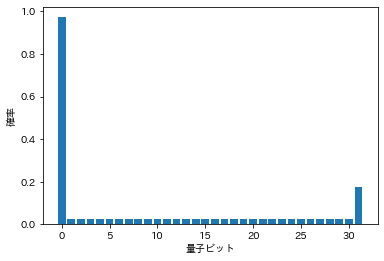

0.17761230468749936


In [19]:
# 何回か繰り返す
## 内積を評価するために 解状態 |1...1> を作っておく
target_state = QuantumState(nqubits)
target_state.set_computational_basis(2**nqubits-1) ## 2**n_qubits-1 は 2進数で 1...1

## グローバーのアルゴリズムの実行
state = QuantumState(nqubits)
state.set_zero_state()

Hadamard.update_quantum_state(state)

avg_result = []
for i in range(4):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    show_distribution(state,nqubits)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

0.06249999999999995
0.11718749999999978
0.15722656249999956
0.17761230468749936
0.17579650878906175
0.15200614929199144
0.10921502113342227
0.052772015333175396
0.010267492383718288
0.0720235635526471


Text(0, 0.5, '確率')

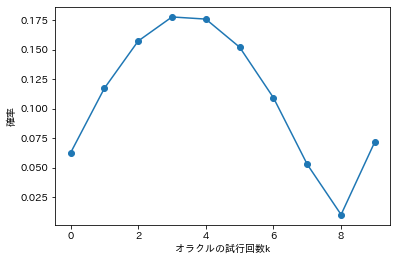

In [20]:
Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
## 初期状態の準備
state = QuantumState(nqubits)
state.set_zero_state()
Hadamard.update_quantum_state(state)

avg_result = []
times = 10
for i in range(times):
    U_w.update_quantum_state(state)
    U_s.update_quantum_state(state)
    fuga = np.linalg.norm(inner_product(state, target_state))
    avg_result.append(fuga)
    print(fuga)

plt.plot(avg_result, "-o")
plt.xlabel('オラクルの試行回数k')
plt.ylabel('確率')

In [21]:
max_result = []
# グローバーのアルゴリズム
def noisy_grover(nqubits, operate_times, dephasing_rate):
    state = QuantumState(nqubits)
    state.set_zero_state()

    # 内積を評価するために 解状態 |1...1> を作っておく
    target_state = QuantumState(nqubits)
    target_state.set_computational_basis(2 ** nqubits - 1) # 2**n_qubits-1 は 2進数で 1...1

    # グローバーのアルゴリズムの実行
    # Hadamard = make_Hadamard(nqubits)
    Noisy_Hadamard = make_noisy_Hadamard(nqubits, dephasing_rate)
    U_w = make_U_w(nqubits)
    U_s = make_U_s(nqubits)

    result = []

    state = QuantumState(nqubits)
    state.set_zero_state()
    Noisy_Hadamard.update_quantum_state(state)
    for k in range(operate_times):
        U_w.update_quantum_state(state)
        U_s.update_quantum_state(state)
        fuga = np.linalg.norm(inner_product(state, target_state))
        result.append(fuga)
        # print(fuga)


    max_k = np.argmax(result)
    max_result.append(result[max_k])

    print(f'maximal probability {result[max_k]:5e} is obtained at k = {max_k + 1}')

    plt.plot(result, "o-")
    plt.xlabel('オラクルの回数k')
    plt.ylabel('確率')

maximal probability 1.776123e-01 is obtained at k = 4


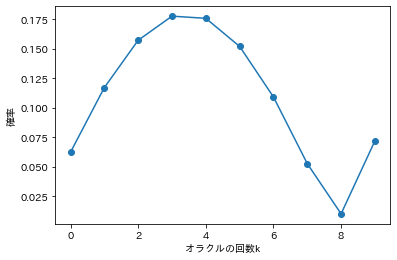

In [22]:
noisy_grover(5, 10, 0.5)

0.0
maximal probability 9.995911e-01 is obtained at k = 4
0.1
maximal probability 7.104492e-01 is obtained at k = 4
0.2
maximal probability 7.104492e-01 is obtained at k = 4
0.30000000000000004
maximal probability 9.995911e-01 is obtained at k = 4
0.4
maximal probability 5.023635e-01 is obtained at k = 4
0.5
maximal probability 7.104492e-01 is obtained at k = 4
0.6000000000000001
maximal probability 2.511817e-01 is obtained at k = 4
0.7000000000000001
maximal probability 2.511817e-01 is obtained at k = 4
0.8
maximal probability 3.552246e-01 is obtained at k = 4
0.9
maximal probability 1.776123e-01 is obtained at k = 4
1.0
maximal probability 1.776123e-01 is obtained at k = 4


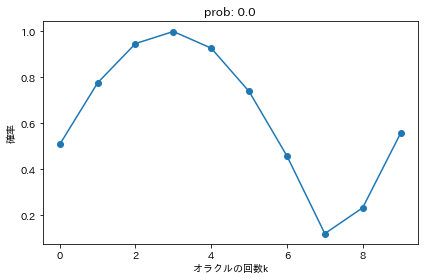

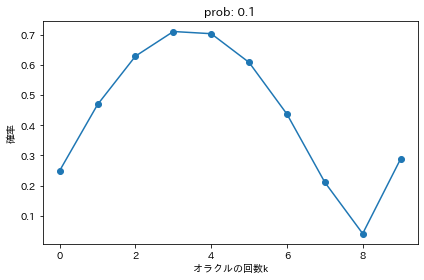

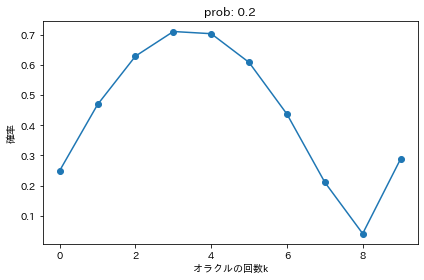

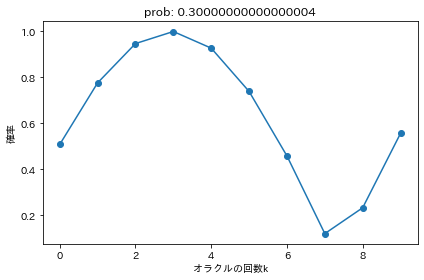

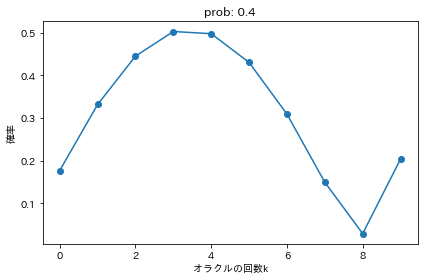

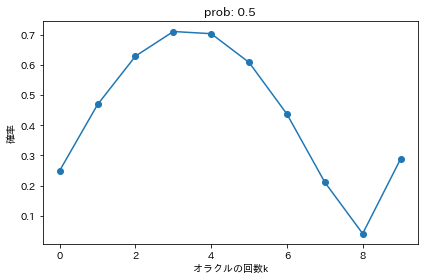

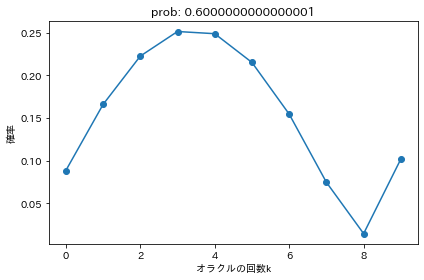

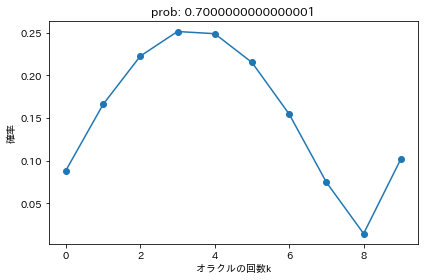

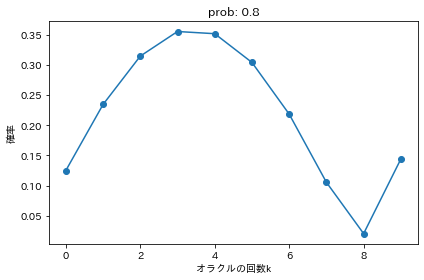

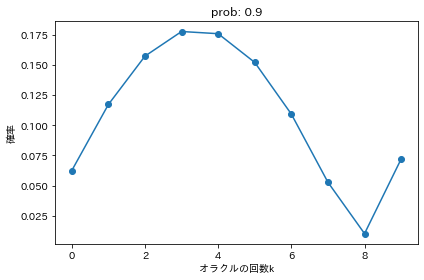

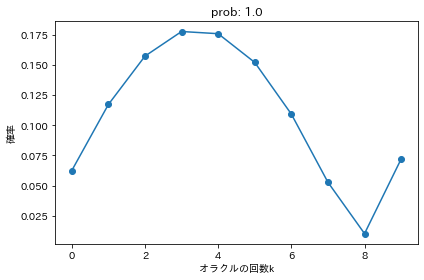

In [23]:
max_result = []
for i in range(0, 11):
    x = i * 0.1
    print(x)
    plt.subplots(1, 1, tight_layout = True)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.title(f'prob: {x}')
    noisy_grover(5, 10, x)

In [24]:
max_result = []
def noisy_I_grover(nqubits, times):
    for i in range(0, 11):
        x = i * 0.1
        noisy_grover(5, 10, x)
    # print(max_result)
    # plt.plot(max_result)

maximal probability 9.995911e-01 is obtained at k = 4
maximal probability 9.995911e-01 is obtained at k = 4
maximal probability 9.995911e-01 is obtained at k = 4
maximal probability 5.023635e-01 is obtained at k = 4
maximal probability 2.511817e-01 is obtained at k = 4
maximal probability 2.511817e-01 is obtained at k = 4
maximal probability 1.776123e-01 is obtained at k = 4
maximal probability 5.023635e-01 is obtained at k = 4
maximal probability 2.511817e-01 is obtained at k = 4
maximal probability 2.511817e-01 is obtained at k = 4
maximal probability 1.776123e-01 is obtained at k = 4


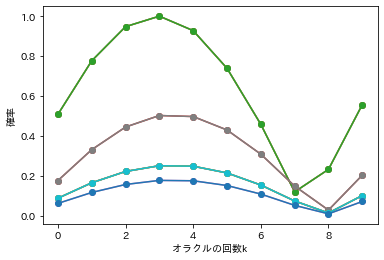

In [25]:
noisy_I_grover(5, 10)

[0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.502363460266808, 0.2511817301334041, 0.2511817301334041, 0.17761230468749936, 0.5023634602668081, 0.2511817301334041, 0.2511817301334041, 0.17761230468749936]


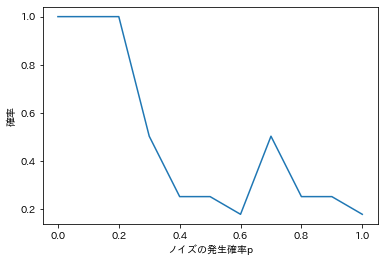

In [26]:
print(max_result)
plt.plot(max_result)
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')

plt.show()


maximal probability 9.995911e-01 is obtained at k = 4
maximal probability 9.995911e-01 is obtained at k = 4
maximal probability 7.104492e-01 is obtained at k = 4
maximal probability 5.023635e-01 is obtained at k = 4
maximal probability 3.552246e-01 is obtained at k = 4
maximal probability 7.104492e-01 is obtained at k = 4
maximal probability 3.552246e-01 is obtained at k = 4
maximal probability 2.511817e-01 is obtained at k = 4
maximal probability 3.552246e-01 is obtained at k = 4
maximal probability 3.552246e-01 is obtained at k = 4
maximal probability 1.776123e-01 is obtained at k = 4
maximal probability 9.995911e-01 is obtained at k = 4
maximal probability 9.995911e-01 is obtained at k = 4
maximal probability 7.104492e-01 is obtained at k = 4
maximal probability 7.104492e-01 is obtained at k = 4
maximal probability 5.023635e-01 is obtained at k = 4
maximal probability 3.552246e-01 is obtained at k = 4
maximal probability 5.023635e-01 is obtained at k = 4
maximal probability 5.023635

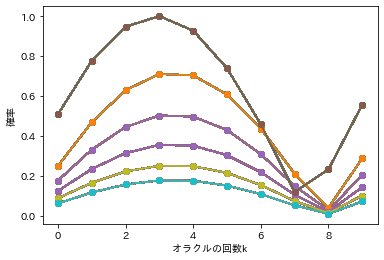

In [27]:
sample_data_times = 100 # サンプルを集める試行回数
nqubits = 5
total_result = []
for i in range(sample_data_times):
    max_result = []
    noisy_I_grover(global_nqubits, 10)
    # print(f'max result:{max_result}')
    total_result.append(max_result)

[0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723]
[0.9995910741614723, 0.9995910741614723, 0.7104492187499974, 0.9995910741614723, 0.9995910741614723]
[0.7104492187499972, 0.7104492187499972, 0.5023634602668081, 0.7104492187499972, 0.9995910741614723]
[0.502363460266808, 0.7104492187499972, 0.7104492187499972, 0.502363460266808, 0.7104492187499974]
[0.3552246093749988, 0.5023634602668081, 0.502363460266808, 0.7104492187499972, 0.502363460266808]
[0.7104492187499972, 0.3552246093749987, 0.502363460266808, 0.5023634602668081, 0.3552246093749987]
[0.3552246093749987, 0.502363460266808, 0.17761230468749936, 0.17761230468749936, 0.7104492187499974]
[0.25118173013340406, 0.502363460266808, 0.2511817301334041, 0.502363460266808, 0.25118173013340406]
[0.3552246093749987, 0.25118173013340406, 0.2511817301334041, 0.17761230468749936, 0.25118173013340406]
[0.3552246093749988, 0.2511817301334041, 0.2511817301334041, 0.17761230468749936, 0.17761230

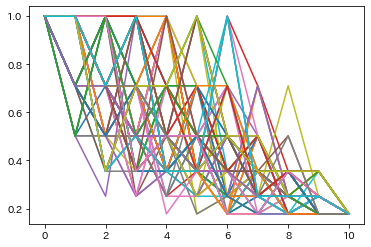

In [28]:
for j in total_result:
    plt.plot(j)

result = []
for i in range(10 + 1):
    hoge = []
    for j in range(nqubits):
        tmp = total_result[j][i]
        hoge.append(tmp)
    print(hoge)
    result.append(hoge)

[[0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723, 0.9995910741614723], [0.9995910741614723, 0.9995910741614723, 0.7104492187499974, 0.9995910741614723, 0.9995910741614723], [0.7104492187499972, 0.7104492187499972, 0.5023634602668081, 0.7104492187499972, 0.9995910741614723], [0.502363460266808, 0.7104492187499972, 0.7104492187499972, 0.502363460266808, 0.7104492187499974], [0.3552246093749988, 0.5023634602668081, 0.502363460266808, 0.7104492187499972, 0.502363460266808], [0.7104492187499972, 0.3552246093749987, 0.502363460266808, 0.5023634602668081, 0.3552246093749987], [0.3552246093749987, 0.502363460266808, 0.17761230468749936, 0.17761230468749936, 0.7104492187499974], [0.25118173013340406, 0.502363460266808, 0.2511817301334041, 0.502363460266808, 0.25118173013340406], [0.3552246093749987, 0.25118173013340406, 0.2511817301334041, 0.17761230468749936, 0.25118173013340406], [0.3552246093749988, 0.2511817301334041, 0.2511817301334041, 0.17761230468749936, 

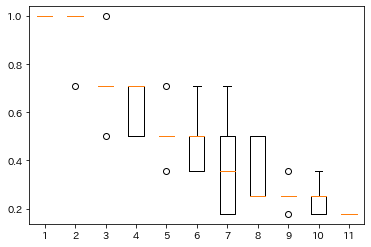

In [29]:
boxplot_result = result
print(boxplot_result)
plt.boxplot(boxplot_result)
plt.show()

平均結果:[0.9995910741614724, 0.9417627030791774, 0.7266604381356544, 0.6272149153567216, 0.5145528417850841, 0.4851250716067222, 0.38465237955336057, 0.3516544221867657, 0.25727642089254205, 0.24256253580336112, 0.17761230468749936]


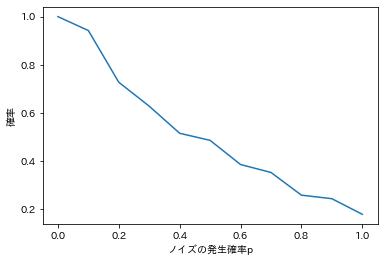

In [30]:
avg_result = []
scores = result

for score in scores:
    avg = np.mean(score)
    avg_result.append(avg)
print(f'平均結果:{avg_result}')
plt.plot(avg_result)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')
plt.show()

分散：[1.232595164407831e-32, 0.013376482008126439, 0.025117735452892986, 0.010391923892045804, 0.012841323843259153, 0.01702271110981349, 0.04131933156236806, 0.015142142772674439, 0.003210330960814794, 0.00425567777745338, 0.0]


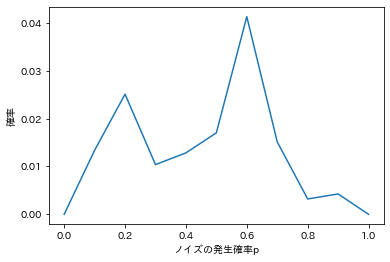

In [31]:
# 分散
variance = []
scores = result
for score in scores:
    v = np.var(score)
    variance.append(v)

print(f'分散：{variance}')

plt.plot(variance)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')
plt.show()

標準偏差：[0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293, 0.2885529152419293]


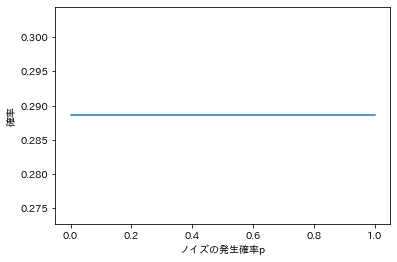

In [32]:
# 標準偏差
scores = result
standard = []
for score in scores:
    std = np.std(scores)
    standard.append(std)

print(f'標準偏差：{standard}')
plt.plot(standard)
# plt.xlabel('オラクルの回数k')
# plt.ylabel('確率')
plt.xlabel('ノイズの発生確率p')
plt.xticks(np.arange(0, 11, 2), [i/10 for i in range(0, 11, 2) ])
plt.ylabel('確率')
plt.show()